## 1. Requirements

In [45]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [14]:
eps = 0.007
use_cuda = False

## 3. Prepare Data

In [4]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [6]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [7]:
normal_data = image_folder_custom_label(root = './data/', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [8]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


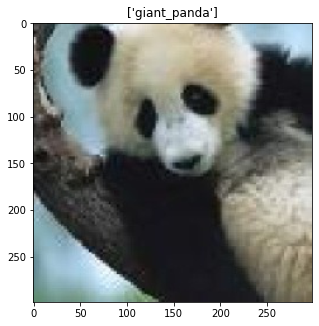

In [9]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

## 4. Download the Inception v3

In [43]:
device = torch.device("cuda" if use_cuda else "cpu")

In [95]:
# model = models.inception_v3(pretrained=True).to(device)
model = torchvision.models.inception_v3(pretrained=True).to(device)
model.eval()


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [80]:
# conservative softmax with polynomial drop 1/x^2, conservative soft = (1/z_i^2)/sum 1/z_k^2, dimension of z: batchsize * num_classes
class conservative_softmax(nn.Module): 
    def __init__(self, num_classes, a):
        super(conservative_softmax, self).__init__()
        self.num_classes = num_classes
        self.a = a
    def forward(self, input):
        nu = []
        pos = []
        for i in range(self.num_classes):
            nu.append(input[:,i] + torch.sqrt(1 + (input[:,i])**2))
        for i in range(self.num_classes):
            pos.append(nu[i]/sum(nu))
        pos = torch.stack(pos, 1)
        return pos

True Image & Predicted Label
tensor([0.0151]) tensor([388])


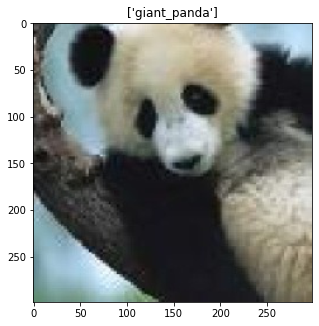

Accuracy of test text: 100.000000 %


In [100]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    softmax = conservative_softmax(1000, 0.1)
#     softmax = nn.Softmax()
    outputs = softmax(outputs)
    
    pos, pre = torch.max(outputs.data, 1)
    print(pos, pre)
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

## 5. Adversarial Attack

In [101]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    softmax = conservative_softmax(1000, 0.1)
#     softmax = nn.Softmax()
    outputs = softmax(outputs)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

In [102]:
# loss = nn.CrossEntropyLoss()
loss = nn.NLLLoss()

Attack Image & Predicted Label
tensor([0.0119]) tensor([384])


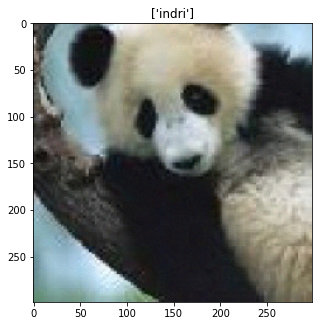

Accuracy of test text: 0.000000 %


In [103]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = fgsm_attack(model, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    softmax = conservative_softmax(1000, 0.1)
#     softmax = nn.Softmax()
    outputs = softmax(outputs)
    
    pos, pre = torch.max(outputs.data, 1)
    print(pos, pre)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))